In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [52]:
weather = pd.read_csv('weather.csv')
rideshare = pd.read_csv('rideshare_kaggle.csv')
rides = pd.read_csv('cab_rides.csv')

In [53]:
rides.isnull().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [54]:
rides.dropna(axis = 0, inplace = True)

In [55]:
weather.isnull().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

In [56]:
weather.fillna(0, inplace = True)

In [57]:
weather_avg = weather.groupby('location').mean().reset_index()
weather_avg.drop(columns = 'time_stamp' , inplace = True)
weather_source = weather_avg.rename(columns =(lambda x :x + '_source'))       
weather_source.rename(columns= {'location_source' :'source'}, inplace = True)
weather_destination = weather_avg.rename(columns =(lambda x :x+'_destination'))       
weather_destination.rename(columns= {'location_destination' :'destination'} ,inplace = True)
data = rides\
       .merge(weather_source ,on ='source')\
       .merge(weather_destination ,on = 'destination')

#binary encoding to cab_type

data['cab_type'] =data['cab_type'].replace({'Uber':1,'Lyft':0})

def one_hot_encode(df , column , prefix):
    dummy = pd.get_dummies(df[column] ,prefix = prefix)
    df = pd.concat([df , dummy] ,axis =1)
    df =df.drop(column , axis =1)
    
    return df

data = one_hot_encode(data ,column =  'destination' , prefix = 'desti')
data = one_hot_encode(data ,column =  'source' , prefix = 'src')
data = one_hot_encode(data ,column =  'product_id' , prefix = 'pid')
data = one_hot_encode(data ,column =  'name' , prefix = 'nm')

In [62]:
train, test = train_test_split(data, test_size = 0.3)

In [64]:
import os  
os.makedirs('folder/subfolder', exist_ok = True)  
train.to_csv('folder/subfolder/train_final_project.csv') 
test.to_csv('folder/subfolder/test_final_project.csv') 

In [88]:
id_list_train = list(train['id'])
rides['bool'] = rides['id'].isin(id_list_train)
train_original = rides.loc[rides['bool'], :]

id_list_test = list(test['id'])
rides['bool'] = rides['id'].isin(id_list_test)
test_original = rides.loc[rides['bool'], :]

In [90]:
ols_object_basic = smf.ols(formula = 'price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name', data = train_original)
model_basic = ols_object_basic.fit()
model_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.715e+05
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:37:05   Log-Likelihood:            -1.0404e+06
No. Observations:              446583   AIC:                         2.081e+06
Df Residuals:                  446548   BIC:                         2.081e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -0.0113   3.05e-05   -370.154      0.000      -0.011      -0.011
cab_type[T.Uber]                                      -0.7243      0.005   -147.619      0.000      -0.734      -0.715
destination[T.Beacon Hill]                            -0.3016      0.018    -16.503      0.000      -0.337      -0.266
destination[T.Boston University]                      -0.0622      0.015     -4.067      0.000      -0.092      -0.032
destination[T.Fenway]                                 -0.3494      0.015    -23.076      0.000      -0.379      -0.320
destination[T.Financial District]                      0.4051      0.018     22.168      0.000       0.369       0.441
destination[T.Haymarket Square]                        0.1387      0.015      9.022      0.000       0.109       0.169
destination[T.North End]                               0.0298      0.015      1.980      0.048       0.000       0.059
destination[T.North Station]                           0.1883      0.018     10.290      0.000       0.152       0.224
destination[T.Northeastern University]                -0.0413      0.015     -2.759      0.006      -0.071      -0.012
destination[T.South Station]                          -0.0883      0.015     -5.840      0.000      -0.118      -0.059
destination[T.Theatre District]                        0.2561      0.018     14.030      0.000       0.220       0.292
destination[T.West End]                               -0.0478      0.018     -2.621      0.009      -0.084      -0.012
source[T.Beacon Hill]                                 -0.2943      0.018    -16.127      0.000      -0.330      -0.259
source[T.Boston University]                           -0.3080      0.015    -20.003      0.000      -0.338      -0.278
source[T.Fenway]                                      -0.0859      0.015     -5.666      0.000      -0.116      -0.056
source[T.Financial District]                           0.3416      0.018     18.552      0.000       0.306       0.378
source[T.Haymarket Square]                             0.3511      0.016     22.610      0.000       0.321       0.382
source[T.North End]                                    0.5658      0.015     37.614      0.000       0.536       0.595
source[T.North Station]                                0.0749      0.018      4.088      0.000       0.039       0.111
source[T.Northeastern University]                     -0.2984      0.015    -19.752      0.000      -0.328      -0.269
source[T.South Station]                                0.1820      0.015     12.172      0.000       0.153       0.211
source[T.Theatre District]                             0.5386      0.018     29.594      0.000       0.503  

In [91]:
np.sqrt(((test_original.price - model_basic.predict(test_original))**2).mean())

2.504402031953646

In [92]:
np.sqrt(model_basic.mse_resid)

2.4861210002537324

In [93]:
ols_object_distance = smf.ols(formula = 'price~distance', data = train_original)
model_distance = ols_object_distance.fit()
model_distance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                 6.059e+04
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:38:10   Log-Likelihood:            -1.6021e+06
No. Observations:              446583   AIC:                         3.204e+06
Df Residuals:                  446581   BIC:                         3.204e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3375      0.028    363.915      0.000      10.282      10.393
distance       2.8342      0.012    246.145      0.000       2.812       2.857
==============================================================================
Omnibus:                    47381.330   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65616.029
Skew:                           0.852   Prob(JB):                         0.00
Kurtosis:                       3.791   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
np.sqrt(((test_original.price - model_distance.predict(test_original))**2).mean())

8.764931172337134

In [95]:
np.sqrt(model_distance.mse_resid)

8.745974723385276

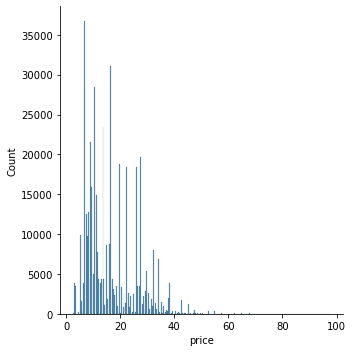

In [96]:
sns.displot(data = train, x = 'price', kind = 'hist')

In [127]:
new_train = train.copy()
new_train = new_train.drop(['price', 'id'], axis = 1)
new_train['log_distance'] = new_train['distance'].apply(lambda x: np.log(x))

In [128]:
new_test = test.copy()
new_test = new_test.drop(['price', 'id'], axis = 1)
new_test['log_distance'] = new_test['distance'].apply(lambda x: np.log(x))

2.1481345197173627

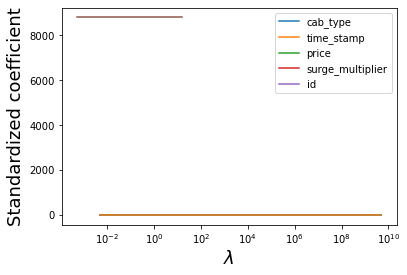

In [129]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

#Taking the log transform of house_price as house prices have a right-skewed distribution
y = np.log(train.price)

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = new_train; 

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Test dataset
Xtest = new_test

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

/Users/michaelkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.60226567900372, tolerance: 14.440040258538652
  model = cd_fast.enet_coordinate_descent(


2.148114692839189

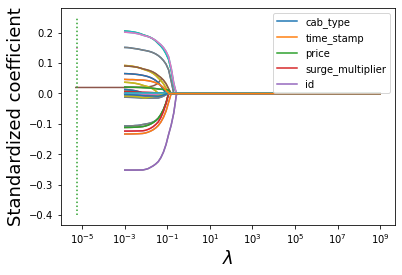

In [130]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)
    
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())